In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os

repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_path)

In [23]:
import pandas as pd
from src.portfolio_maker import HRP, IVP, MVP, ASRP
import numpy as np
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import os


df = pd.read_csv(os.path.join('..','data','binance_usdt_pairs_2018-12-31_2024-01-01_1d.csv'))
df['close'] = pd.to_numeric(df['close'])
df["open_time"] = pd.to_datetime(df["open_time"])
df["returns"] = df.groupby("symbol")["close"].pct_change()
df.head()

,symbol,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_vol,taker_quote_vol,ignore,returns
0,BTCUSDT,2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 23:59:59.999,8.814925e+07,154227,12919.155899,4.797344e+07,0,NaN
1,BTCUSDT,2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 23:59:59.999,1.338766e+08,218538,17921.600114,6.827790e+07,0,0.016175
2,BTCUSDT,2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 23:59:59.999,1.116574e+08,199812,14793.083267,5.617250e+07,0,-0.023786
3,BTCUSDT,2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 23:59:59.999,1.110346e+08,192232,15579.303258,5.861620e+07,0,0.006698
4,BTCUSDT,2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,2019-01-05 23:59:59.999,1.158935e+08,203673,14908.914175,5.666746e+07,0,-0.005551


In [ ]:
# Filter symbols with NaN values after '2023-01-01'
filter_date = pd.Timestamp("2023-01-01")
filtered_symbols = df[df["open_time"] > filter_date].groupby("symbol")["returns"].apply(
    lambda x: x.isna().any()
)
symbols_to_exclude = filtered_symbols[filtered_symbols].index
filtered_df = df[~df["symbol"].isin(symbols_to_exclude)]
filtered_returns_matrix = filtered_df.pivot_table(
    index="open_time", 
    columns="symbol", 
    values="returns"
)

In [37]:
filtered_returns_matrix_post_2023 = filtered_returns_matrix.loc[filtered_returns_matrix.index > filter_date].dropna(axis=1)
filtered_returns_matrix_post_2023

symbol,1INCHUSDT,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,AKROUSDT,ALCXUSDT,...,XRPUSDT,XTZUSDT,XVGUSDT,XVSUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.025907,0.015326,0.017637,0.024173,0.011183,0.015606,0.041629,0.003663,0.036667,0.021583,...,0.028048,0.027816,0.018587,0.031169,0.044915,0.024864,0.061828,-0.001063,0.018428,0.037849
2023-01-03,-0.025253,0.000000,-0.014731,-0.022360,0.019141,-0.003546,-0.014770,0.000000,-0.016077,-0.021127,...,-0.013211,0.021651,-0.014599,0.000000,-0.007443,-0.018935,0.015190,-0.042553,0.000603,-0.010237
2023-01-04,0.023316,0.073585,0.014952,0.026684,0.015860,0.058917,0.022046,0.000000,0.006536,0.014388,...,0.010477,0.017219,0.003704,0.010076,0.007874,0.067551,0.014963,0.000000,0.018686,0.025210
2023-01-05,-0.017722,-0.026362,-0.005199,-0.018564,0.075185,0.005228,0.017256,-0.010949,-0.009740,0.007092,...,-0.026498,-0.007812,-0.003690,0.039900,0.003534,-0.016949,-0.022113,-0.030000,0.004142,-0.010088
2023-01-06,0.023196,0.018051,0.008711,0.007566,-0.026366,0.034918,0.003393,0.007380,-0.003279,0.000000,...,0.018639,0.013123,0.011111,0.028777,0.006858,0.007471,0.040201,-0.027491,0.026517,0.021019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,-0.045343,0.061429,-0.081154,-0.062823,-0.003859,-0.027787,-0.033866,-0.121064,-0.040000,-0.029719,...,0.000946,-0.053058,-0.004573,-0.038095,-0.010829,-0.050865,0.002829,-0.027482,-0.049760,0.026773
2023-12-29,0.006317,-0.053920,0.122669,-0.004591,-0.030024,-0.012179,0.006009,0.035828,-0.027778,0.179636,...,-0.018279,-0.021842,-0.047728,-0.009901,-0.010828,-0.037581,-0.101881,-0.120328,-0.021722,-0.014785
2023-12-30,-0.025110,-0.012892,-0.064685,-0.009686,-0.016975,-0.011836,-0.026879,-0.027671,-0.014286,-0.048772,...,-0.003692,-0.011650,-0.020906,-0.017500,-0.003041,0.000693,-0.000698,-0.013472,-0.009913,-0.003547


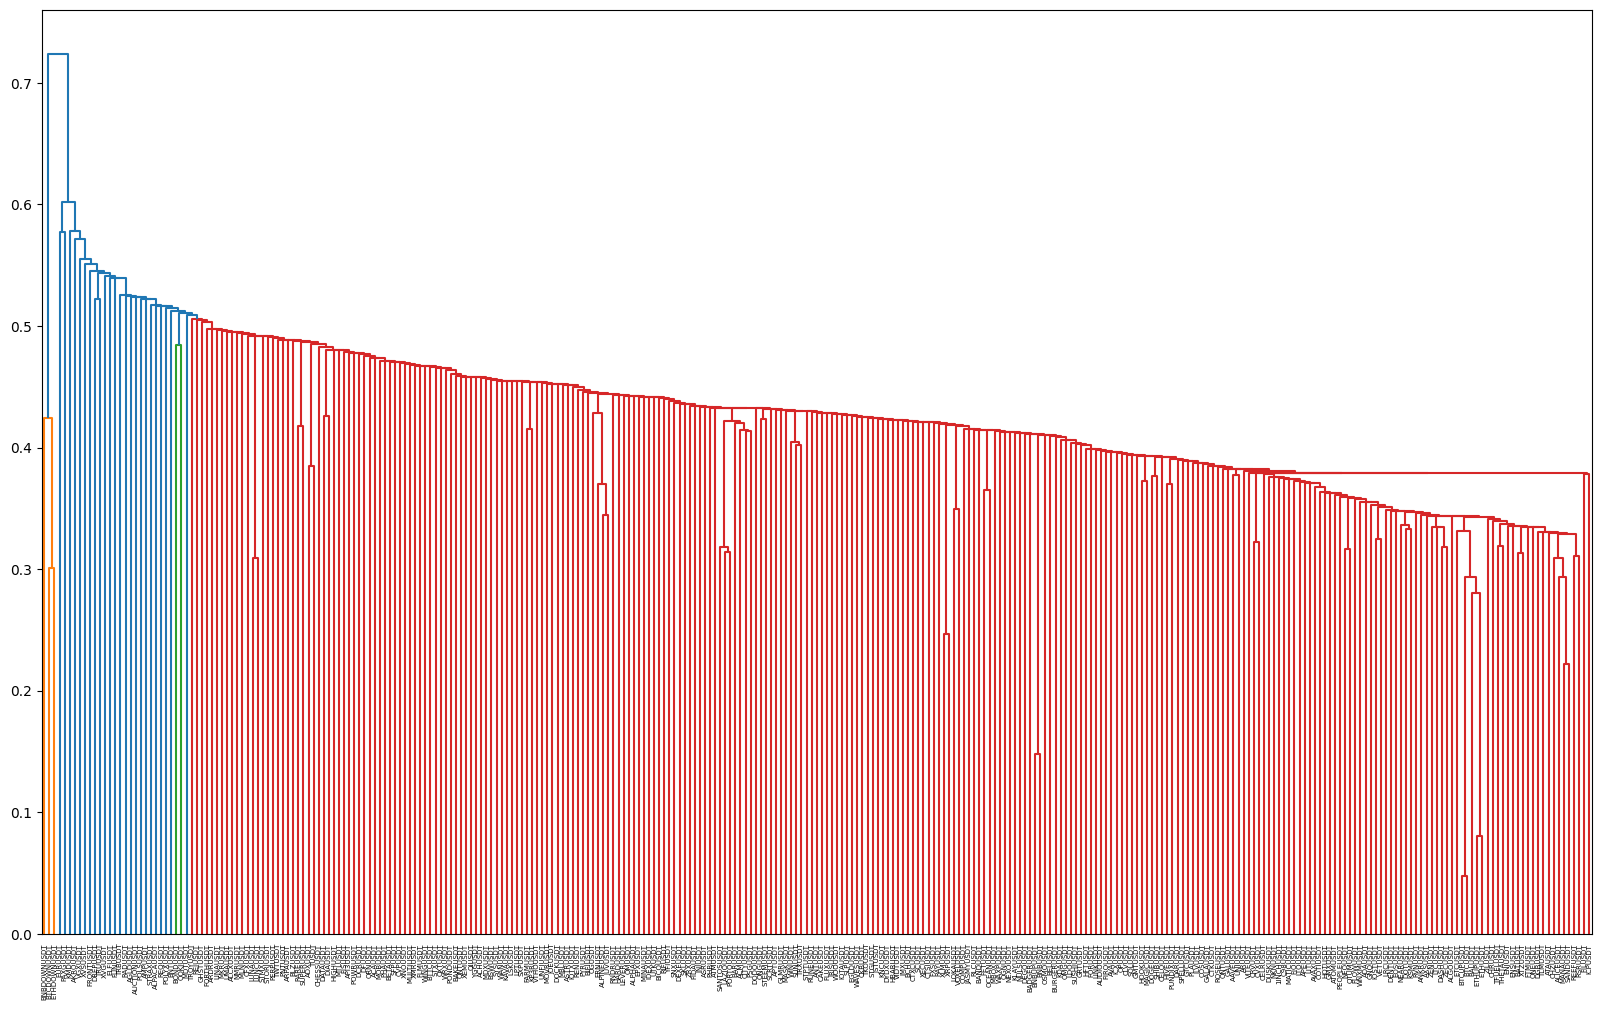

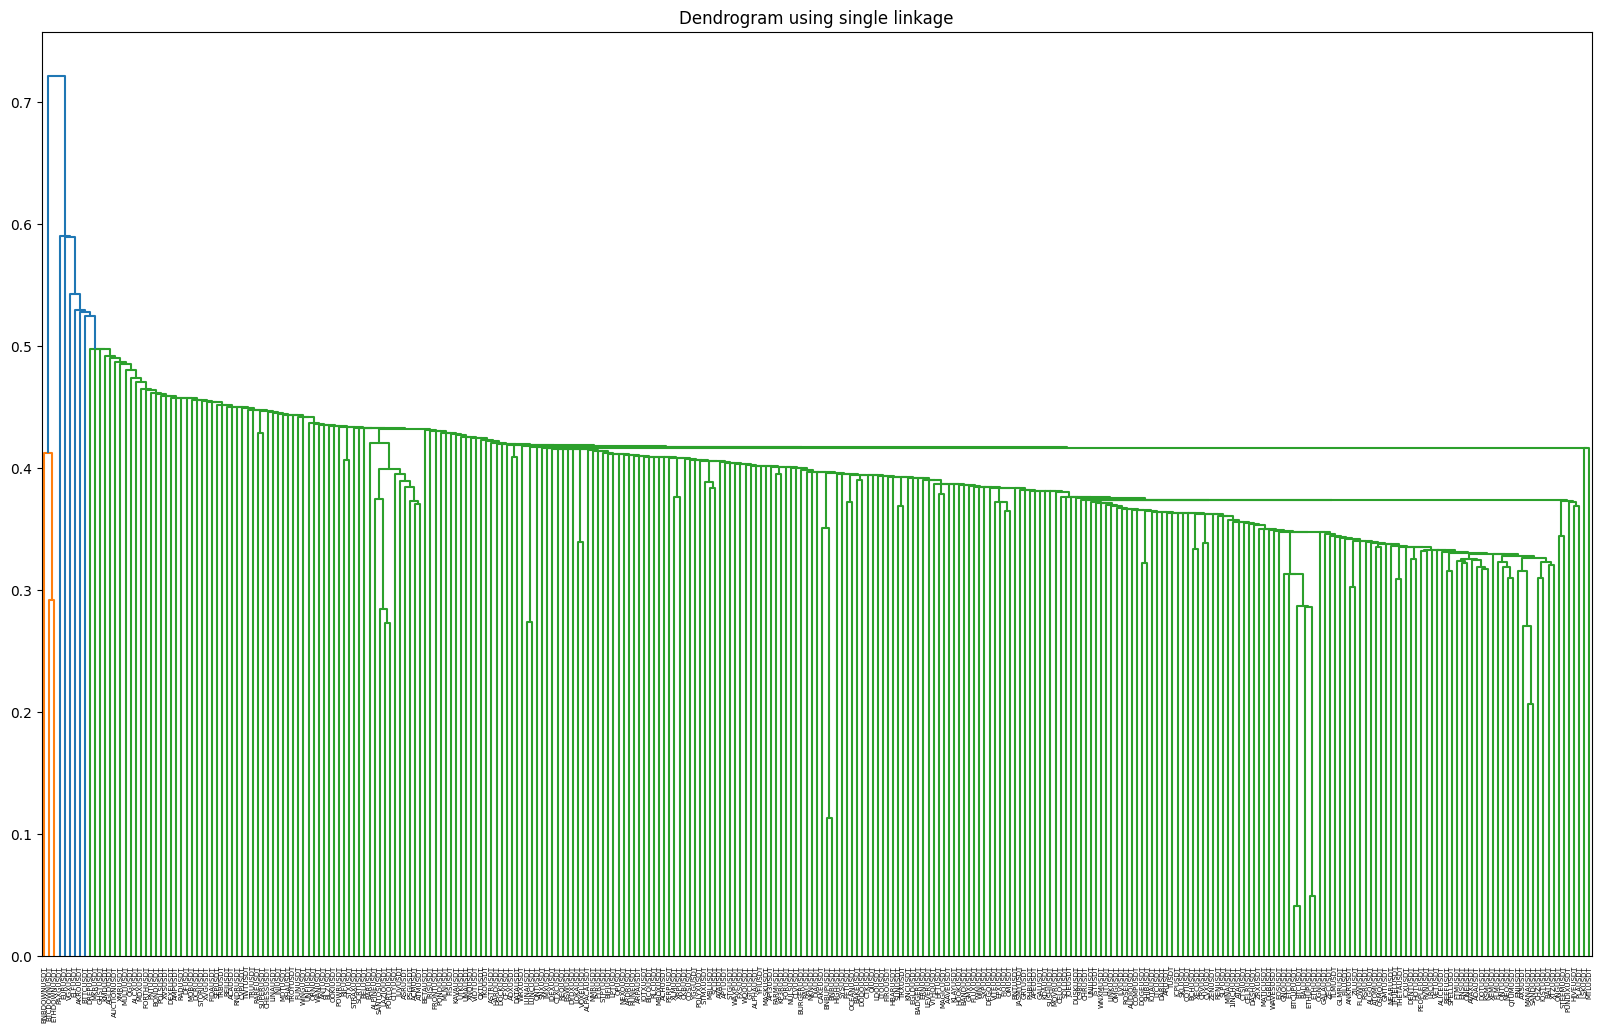

In [ ]:
hrp_strategy = HRP(filtered_returns_matrix_post_2023)
hrp_weights = hrp_strategy.get_weights()

ivp_strategy = IVP(filtered_returns_matrix_post_2023)
ivp_weights = ivp_strategy.get_weights()

mvp_strategy = MVP(filtered_returns_matrix_post_2023)
mvp_weights = mvp_strategy.get_weights()

asrp_strategy = ASRP(filtered_returns_matrix_post_2023)
asrp_weights = asrp_strategy.get_weights()

weights_df = pd.DataFrame({
        "HRP": hrp_weights,
        "IVP": ivp_weights,
        "MVP": mvp_weights,
        "ASRP": asrp_weights
    })

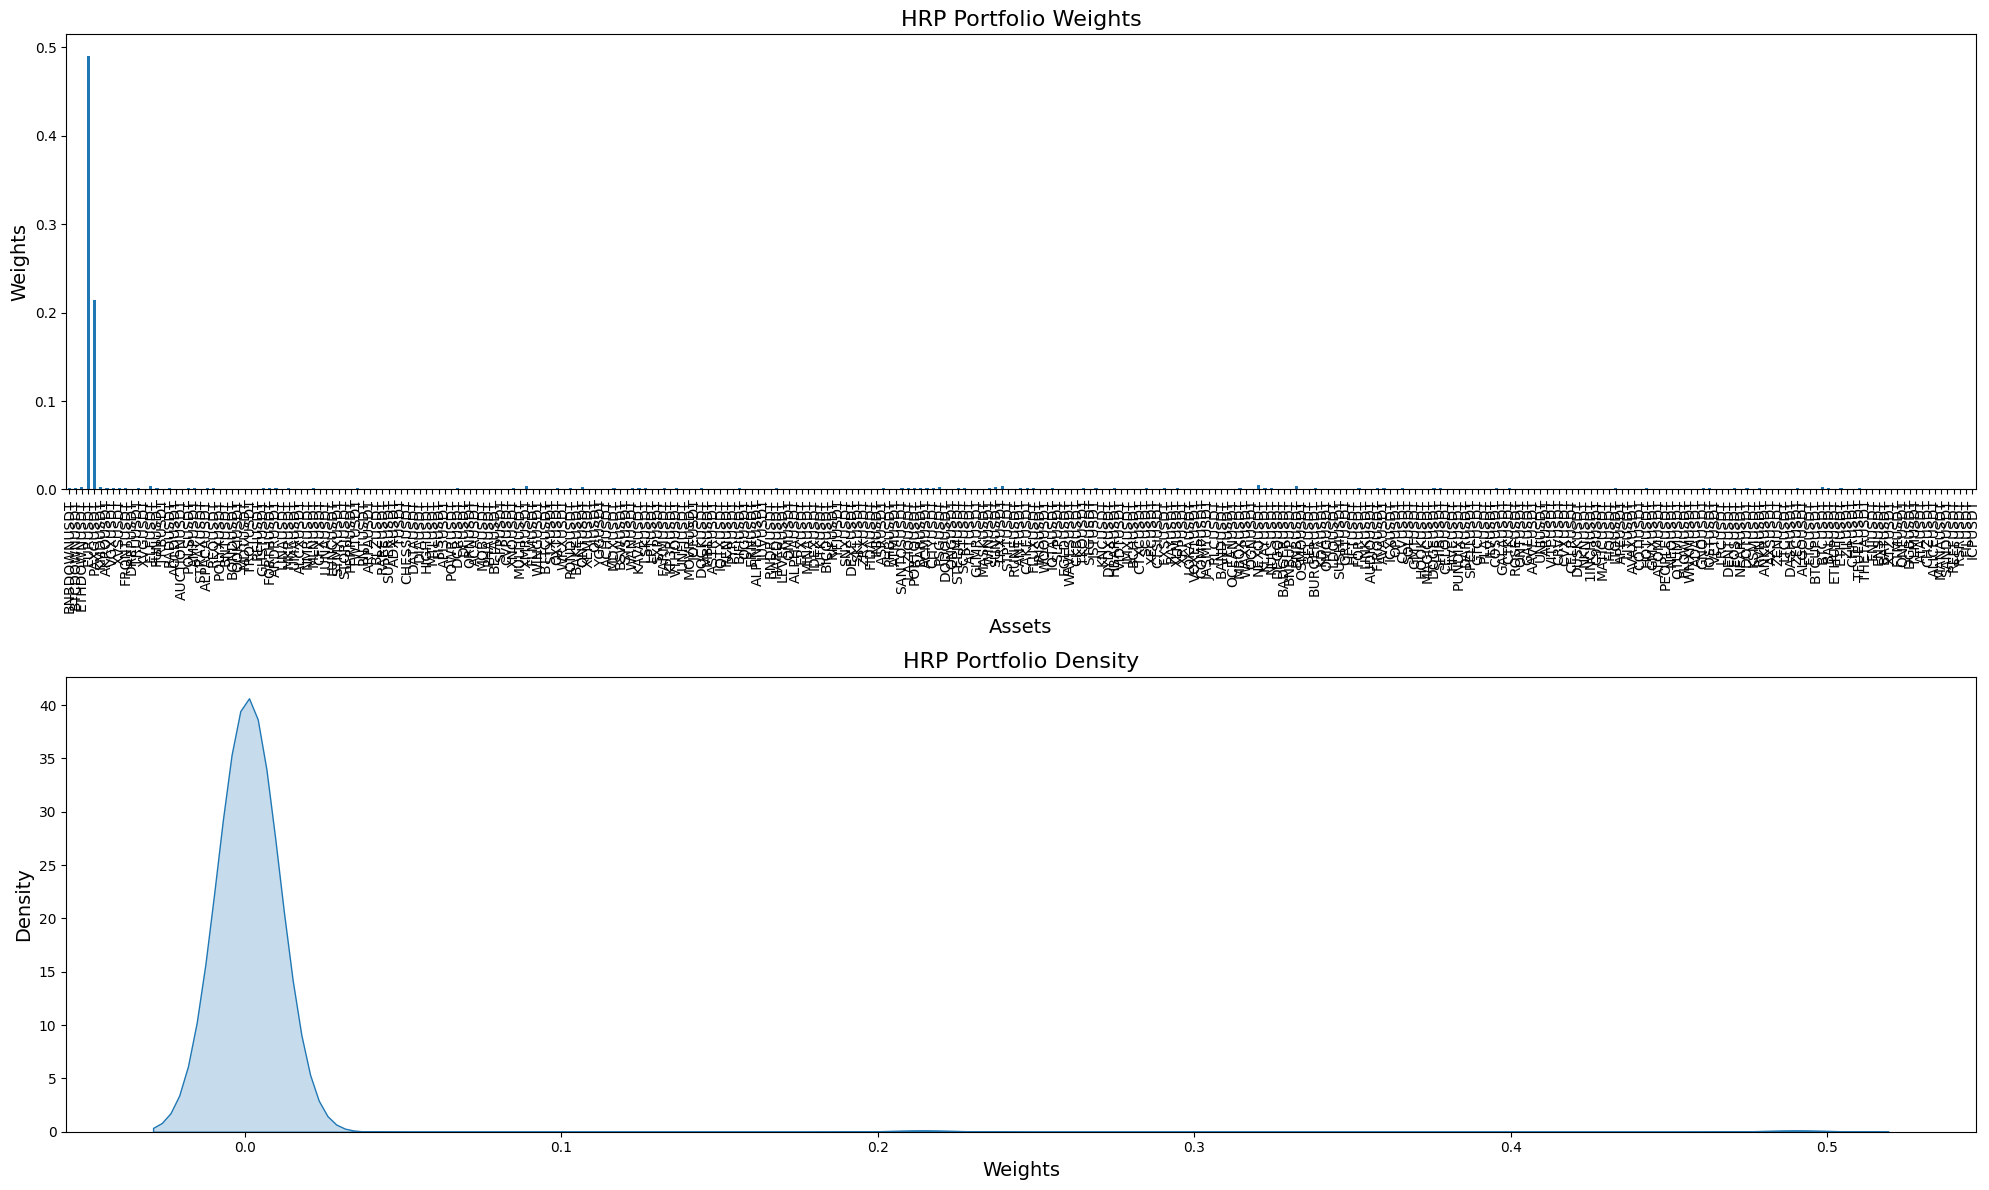

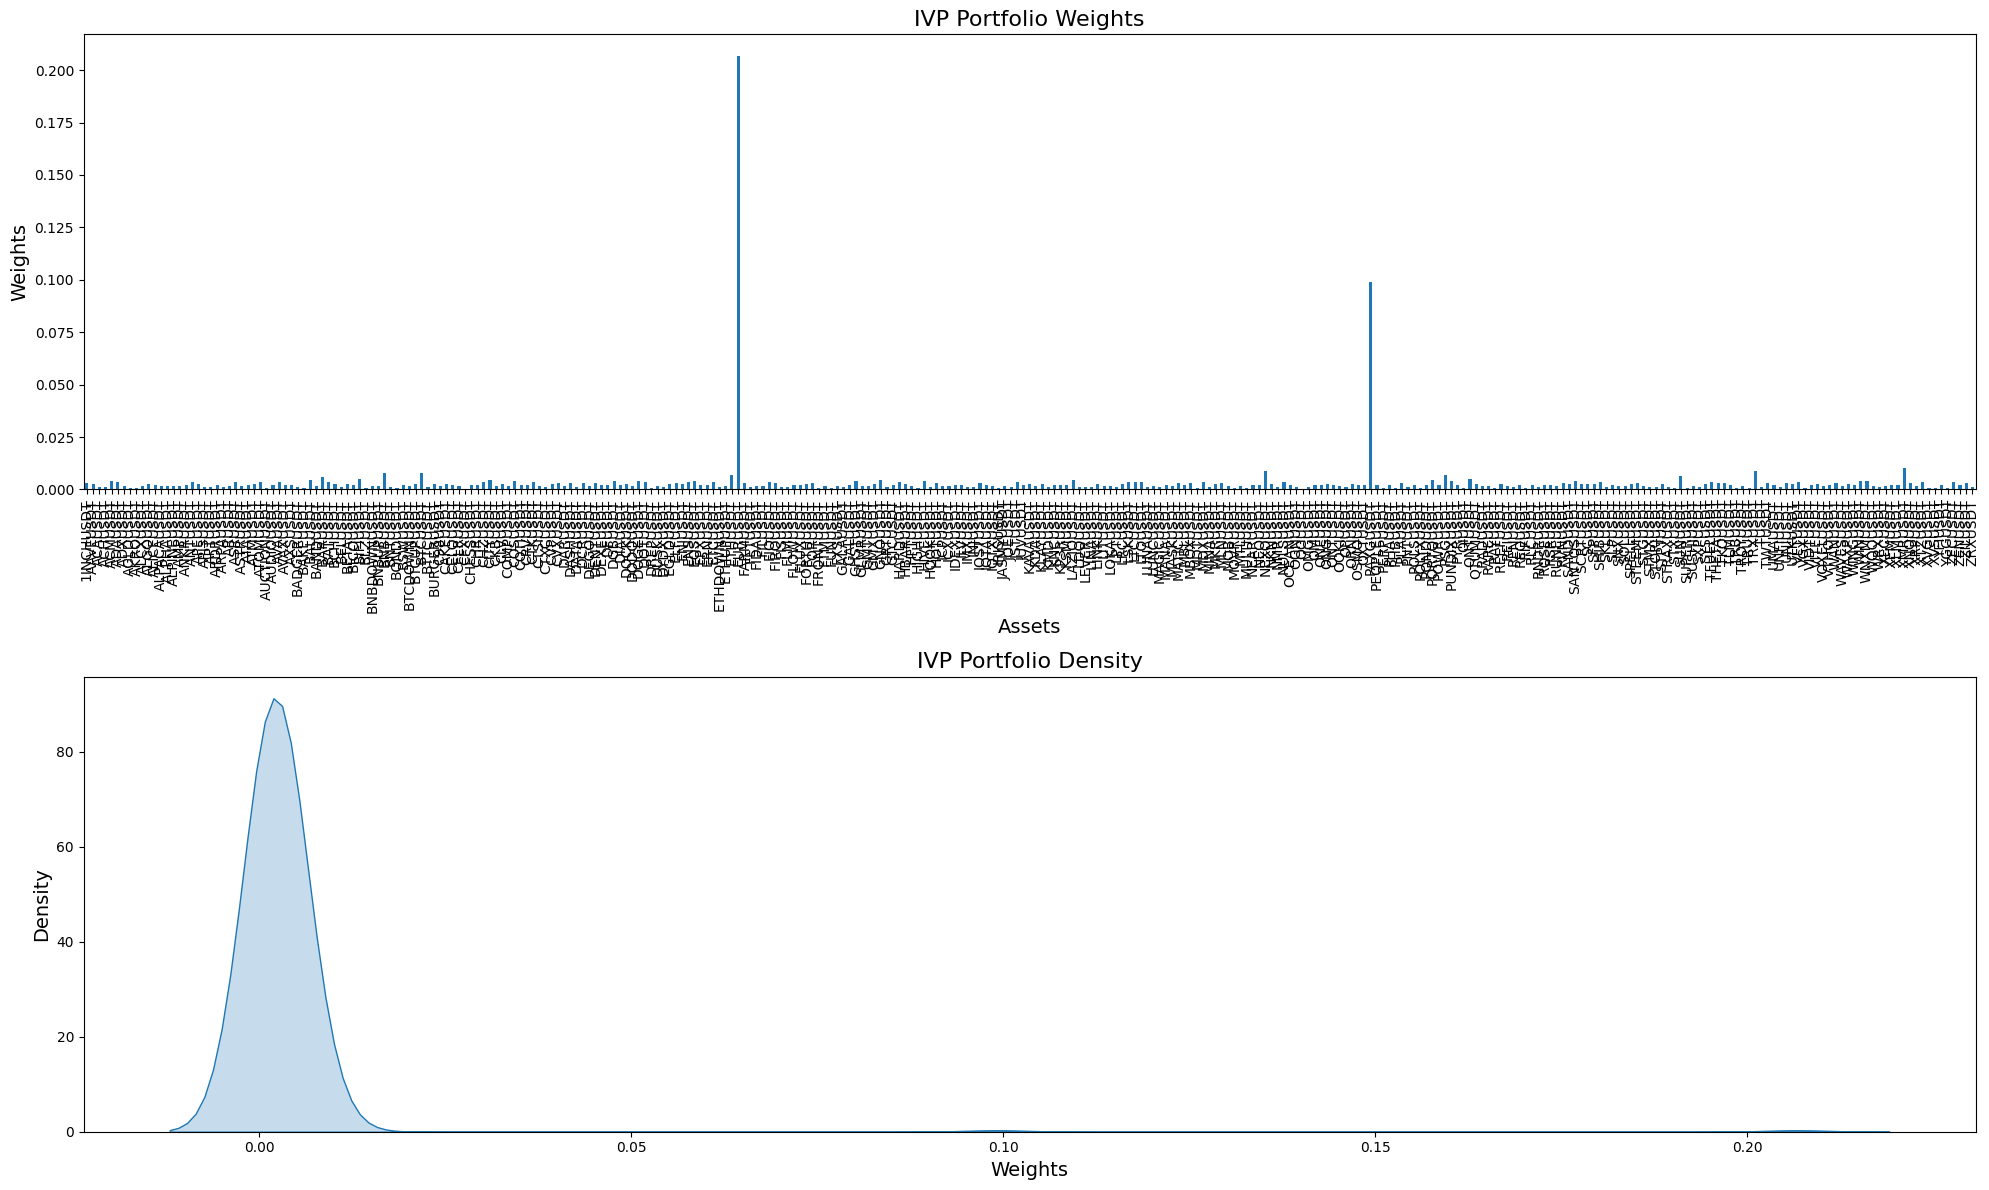

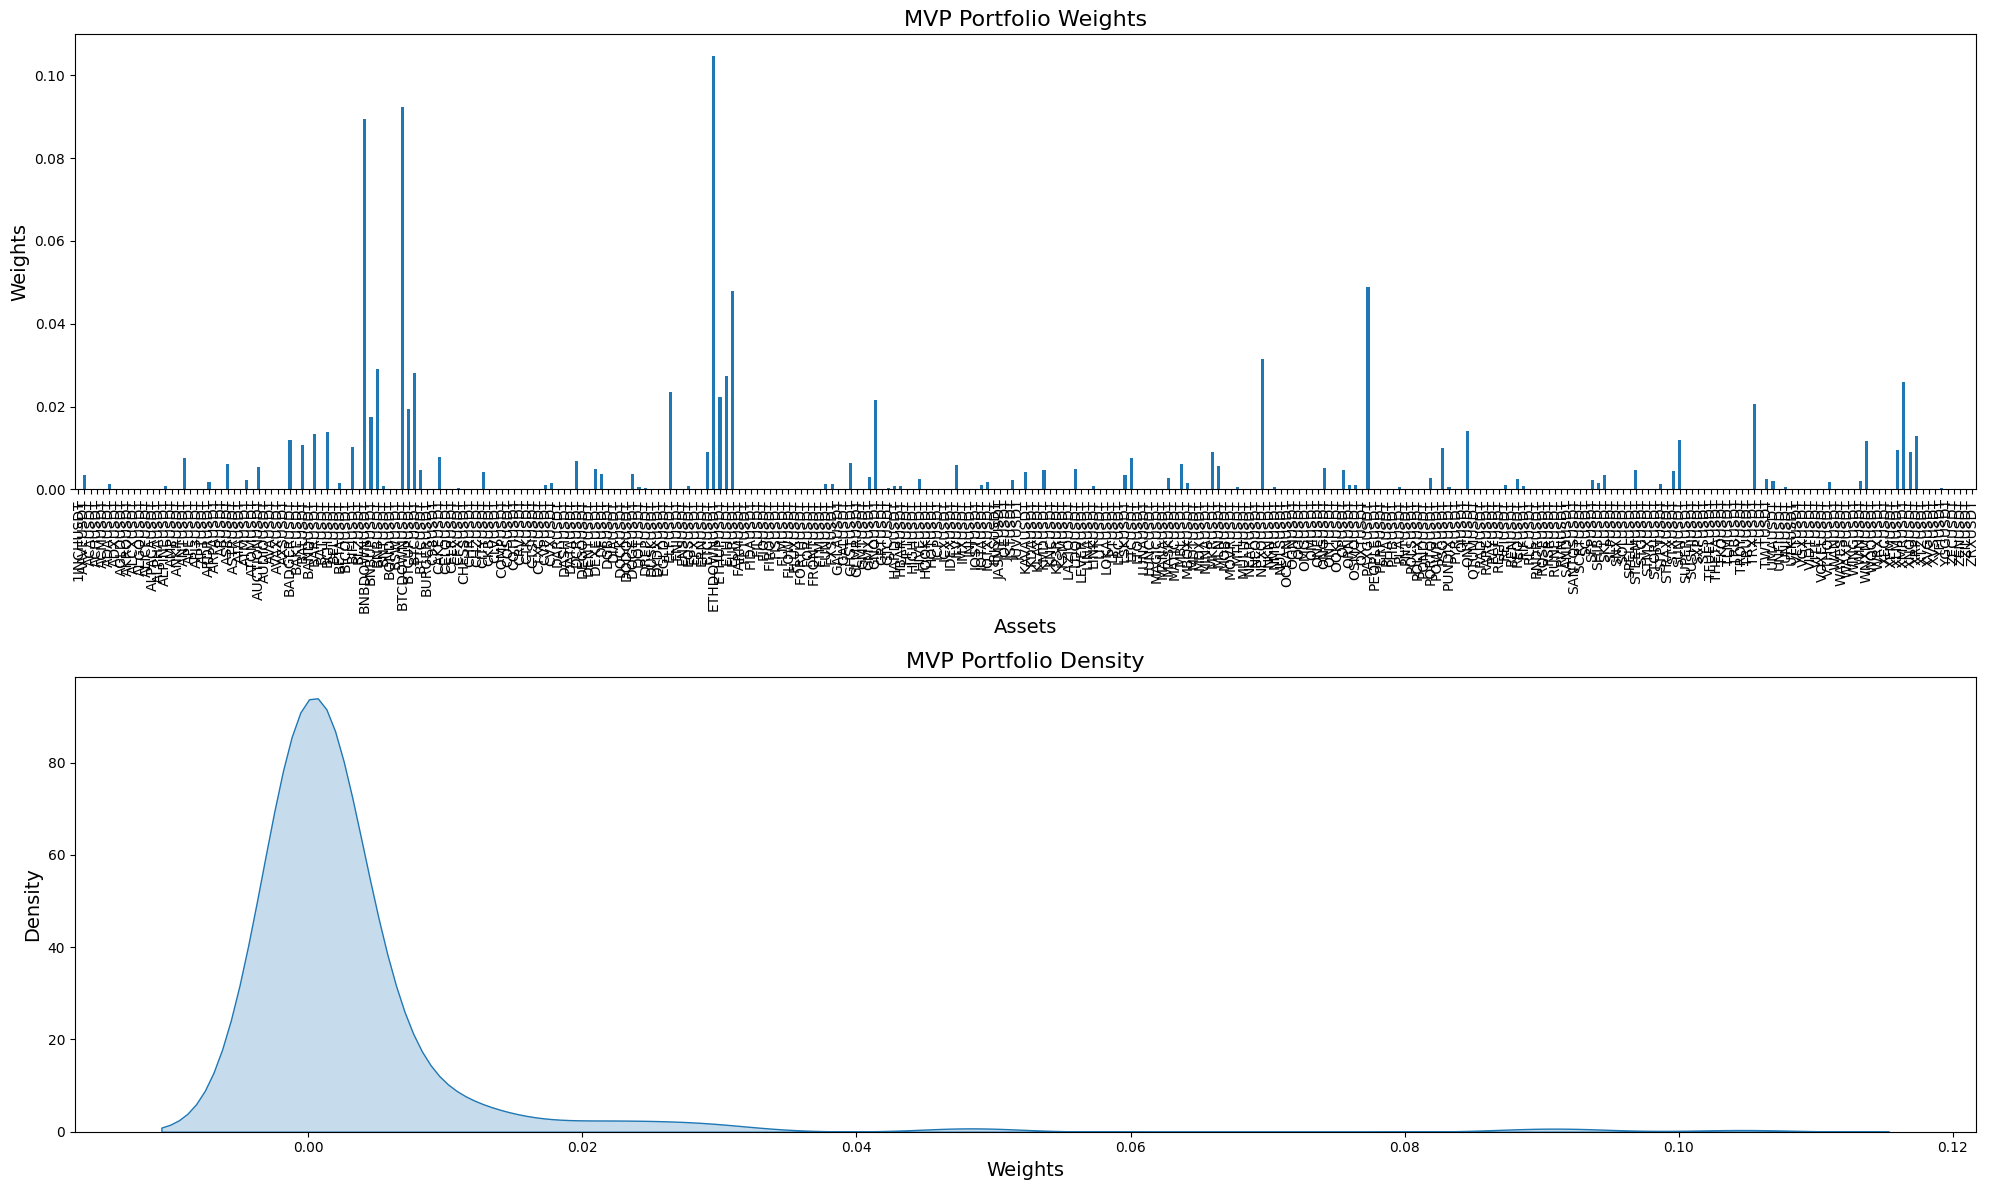

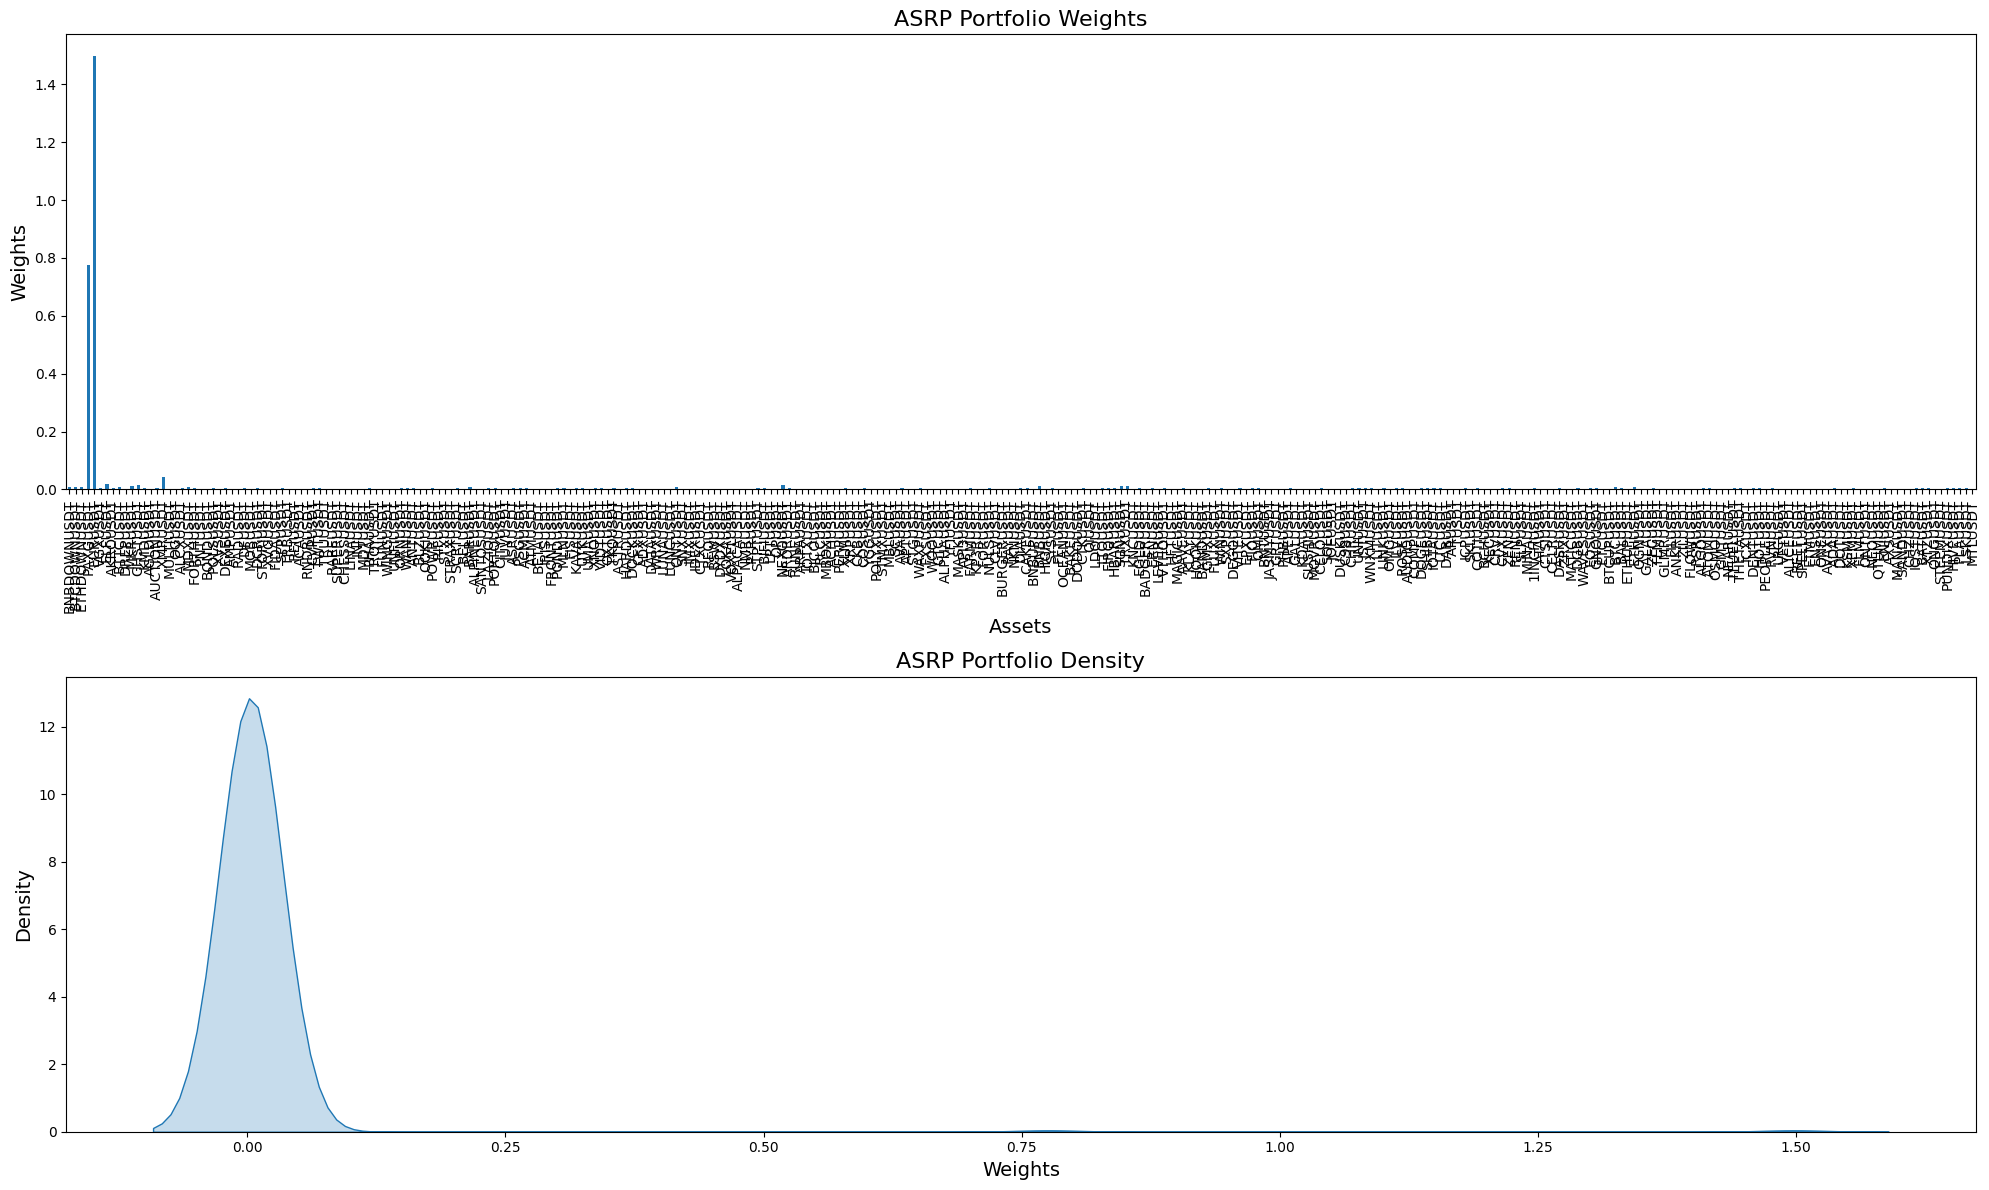

In [ ]:
import seaborn as sns

strategies = {"HRP": hrp_weights, "IVP": ivp_weights, "MVP": mvp_weights, 'ASRP':asrp_weights}

for strategy, weights in strategies.items():
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    weights.plot(kind="bar", ax=axes[0])
    axes[0].set_title(f"{strategy} Portfolio Weights", fontsize=16)
    axes[0].set_xlabel("Assets", fontsize=14)
    axes[0].set_ylabel("Weights", fontsize=14)
    
    sns.kdeplot(weights, ax=axes[1], fill=True)
    axes[1].set_title(f"{strategy} Portfolio Density", fontsize=16)
    axes[1].set_xlabel("Weights", fontsize=14)
    axes[1].set_ylabel("Density", fontsize=14)
    
    plt.tight_layout()
    plt.show()

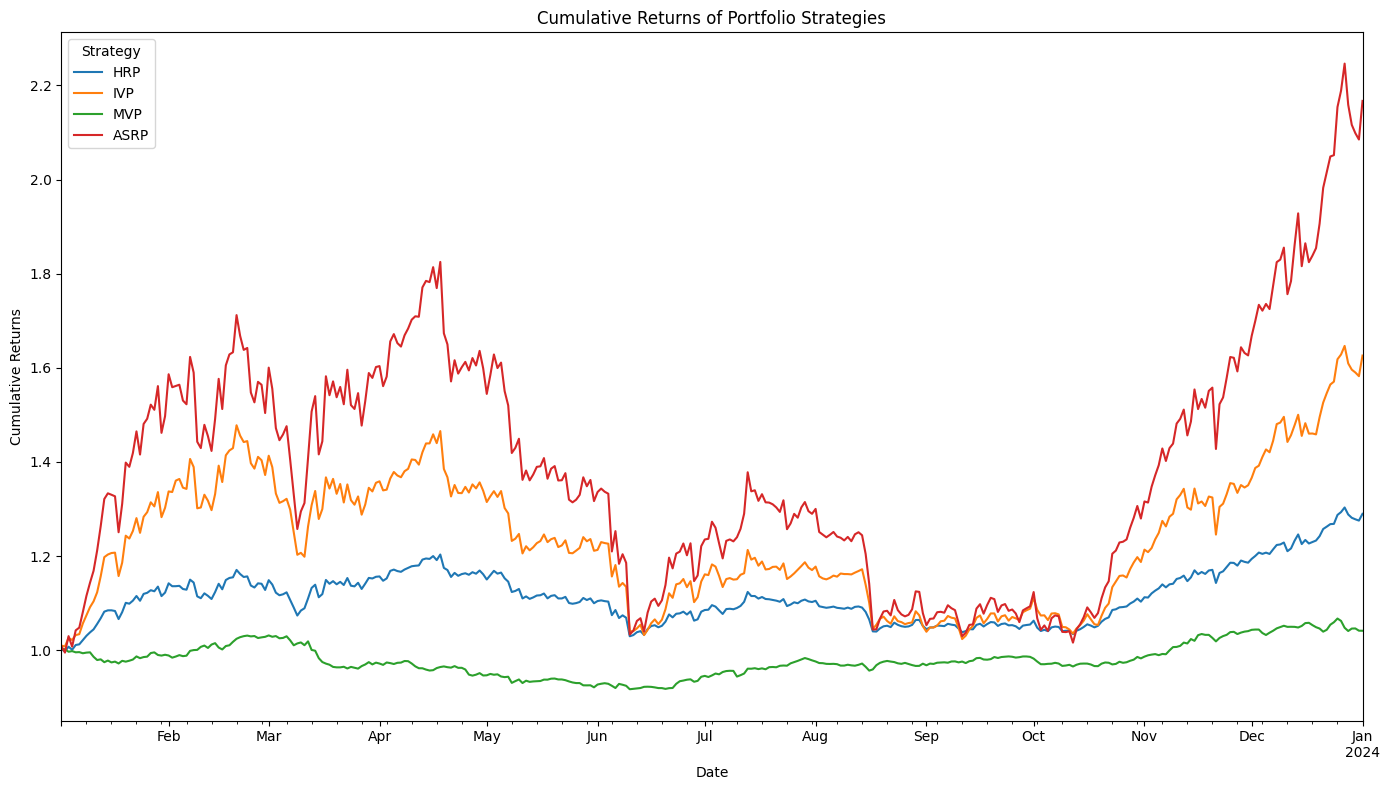

In [ ]:
def calculate_cumulative_returns(returns_matrix, weights):
    """
    Calculate cumulative returns for a portfolio given returns and weights.

    Parameters:
    - returns_matrix: DataFrame of asset returns
    - weights: Series of portfolio weights

    Returns:
    - Series of cumulative returns
    """
    weighted_returns = (returns_matrix * weights).sum(axis=1)
    cumulative_returns = (1 + weighted_returns).cumprod()
    return cumulative_returns

hrp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, hrp_weights)
ivp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, ivp_weights)
mvp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, mvp_weights)
asrp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, asrp_weights)

cumulative_returns = pd.DataFrame({
    "HRP": hrp_cumulative,
    "IVP": ivp_cumulative,
    "MVP": mvp_cumulative,
    "ASRP": asrp_cumulative
})

cumulative_returns.plot(figsize=(14, 8), title="Cumulative Returns of Portfolio Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()
